# RNN for Time Series — From Scratch (NumPy) and PyTorch

This notebook implements a **Recurrent Neural Network (RNN)** in two ways:

1) **From scratch (NumPy):** a minimal RNN trained via **Backpropagation Through Time (BPTT)** on a sine‑wave time series.  
2) **PyTorch:** a compact implementation using `nn.RNN` and a linear head, trained on the same pattern.

The structure and flow of the PyTorch section follow the ideas from Codecademy’s guide *“RNN PyTorch Time Series Tutorial: Complete Guide to Implementation”*. We adapt the steps to a clean, single‑file workflow and add a matching **from‑scratch** reference for educational depth.

Source : https://www.codecademy.com/article/rnn-py-torch-time-series-tutorial-complete-guide-to-implementation


## Imports

Core scientific stack for data handling and visualization, plus PyTorch for the framework‑based model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

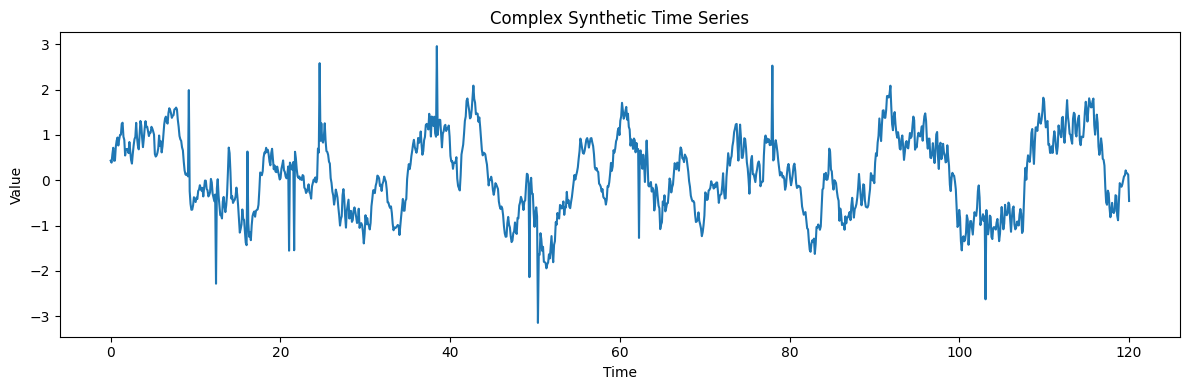

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_complex_series(n_points=1200, t_end=120.0, seed=42):
    rng = np.random.default_rng(seed)
    t = np.linspace(0.0, t_end, n_points)

    # 1) Nonlinear trend
    trend = 0.02 * (t / t_end) + 0.15 * (t / t_end) ** 2

    # 2) Multi-seasonality
    slow = 0.8  * np.sin(2*np.pi * t / 18.0)
    med  = 0.35 * np.sin(2*np.pi * t / 3.5 + 0.6)
    fast = 0.12 * np.sin(2*np.pi * t / 0.7 + 1.3)

    # 3) Chirp (frequency increases)
    f0, k = 0.03, 0.015
    chirp = 0.45 * np.sin(2*np.pi * (f0*t + 0.5 * k * (t**2) / t_end))

    # 4) Regime shift + a new high-freq after t>90
    regime = np.ones_like(t)
    regime[(t >= 40) & (t <= 70)] = 1.7
    regime_component = regime * (0.4 * np.sin(2*np.pi * t / 6.0 + 0.3))
    post90 = np.where(t > 90, 0.2 * np.sin(2*np.pi * t / 0.45), 0.0)

    # 5) Heteroscedastic AR(1) noise
    sigma_t = 0.08 + 0.12 * (np.sin(2*np.pi * t / 12.0) + 1.0) / 2.0
    rho = 0.65
    eps = np.zeros_like(t)
    base_noise = rng.normal(0.0, 1.0, size=t.shape)
    for i in range(1, len(t)):
        eps[i] = rho * eps[i-1] + sigma_t[i] * base_noise[i]

    # 6) Spikes/outliers (~1%)
    y = trend + slow + med + fast + chirp + regime_component + post90 + eps
    n_spikes = int(0.01 * n_points)
    idx = rng.choice(n_points, size=n_spikes, replace=False)
    sign = rng.choice([-1.0, 1.0], size=n_spikes)
    y[idx] += sign * 2.5 * np.std(y)

    return t, y

# Generate + plot
t, y = generate_complex_series()
df = pd.DataFrame({"time": t, "value": y})

plt.figure(figsize=(12, 4))
plt.plot(df["time"], df["value"])
plt.title("Complex Synthetic Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


## Generate a Synthetic Time Series (Sine Wave)

We will create a clean periodic signal to make learning behavior obvious.

In [ ]:
df.head()

,time,value
0,0.000000,0.431460
1,0.100083,0.388322
2,0.200167,0.572984
3,0.300250,0.716230
4,0.400334,0.429198


## Visualize the Raw Series

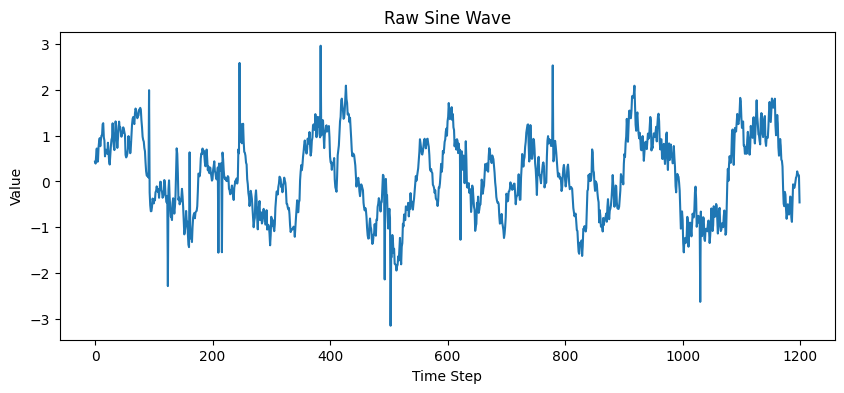

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['value'])
plt.title("Raw Sine Wave")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()

## Preprocess and Create Sequences

- **Scale** values to `[0, 1]` using `MinMaxScaler`.
- **Window the series** into input sequences of length `SEQ_LEN`, with the **label** being the value immediately following the window.

In [ ]:
scaler = MinMaxScaler()
df['value'] = scaler.fit_transform(df[['value']])
series = df['value'].values

def create_sequences(arr, seq_len: int):
    xs, ys = [], []
    for i in range(len(arr) - seq_len):
        x = arr[i:i+seq_len]
        y = arr[i+seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LEN = 20
X, y = create_sequences(series, SEQ_LEN)

# Split without shuffling to respect temporal order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Torch tensors for the PyTorch section
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # (batch, seq, input_size=1)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, X_test.shape

((944, 20), (236, 20))

# Part I — RNN From Scratch (NumPy)

We implement a **single‑layer tanh RNN** with a linear output head. The training objective is **MSE** between the predicted next value and the true next value.

In [ ]:
class RNNFromScratch:
    def __init__(self, input_size: int, hidden_size: int, output_size: int, lr: float = 1e-2, clip: float = 5.0):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = lr
        self.clip = clip

        # Xavier-like init
        bound_in = np.sqrt(6.0 / (input_size + hidden_size))
        bound_hh = np.sqrt(6.0 / (hidden_size + hidden_size))
        bound_out = np.sqrt(6.0 / (hidden_size + output_size))

        self.Wxh = np.random.uniform(-bound_in, bound_in, (hidden_size, input_size))
        self.Whh = np.random.uniform(-bound_hh, bound_hh, (hidden_size, hidden_size))
        self.bh  = np.zeros((hidden_size,))

        self.Why = np.random.uniform(-bound_out, bound_out, (output_size, hidden_size))
        self.by  = np.zeros((output_size,))

        # Grad buffers
        self.dWxh = np.zeros_like(self.Wxh)
        self.dWhh = np.zeros_like(self.Whh)
        self.dbh  = np.zeros_like(self.bh)
        self.dWhy = np.zeros_like(self.Why)
        self.dby  = np.zeros_like(self.by)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def dtanh_from_tanh(tanh_out):
        return 1.0 - tanh_out**2

    def forward(self, x_seq):
        # x_seq: (seq_len, input_size)
        assert x_seq.ndim == 2 and x_seq.shape[1] == self.input_size

        h_prev = np.zeros((self.hidden_size,))
        hs = []
        preacts = []
        xs = []

        for t in range(x_seq.shape[0]):
            x_t = x_seq[t]
            xs.append(x_t)
            pre = np.dot(self.Wxh, x_t) + np.dot(self.Whh, h_prev) + self.bh
            h_t = self.tanh(pre)
            preacts.append(pre)
            hs.append(h_t)
            h_prev = h_t

        hs_last = hs[-1]
        y_hat = np.dot(self.Why, hs_last) + self.by  # (output_size,)
        cache = (np.array(xs), np.array(hs), np.array(preacts))
        return y_hat, cache

    def loss(self, y_hat, y_true):
        y_hat = np.asarray(y_hat).reshape(self.output_size)
        y_true = np.asarray(y_true).reshape(self.output_size)
        return 0.5 * np.square(y_hat - y_true).mean()

    def backward(self, y_hat, y_true, cache):
        xs, hs, preacts = cache
        seq_len = xs.shape[0]

        # Reset grads
        self.dWxh.fill(0.0)
        self.dWhh.fill(0.0)
        self.dbh.fill(0.0)
        self.dWhy.fill(0.0)
        self.dby.fill(0.0)

        y_hat = np.asarray(y_hat).reshape(self.output_size)
        y_true = np.asarray(y_true).reshape(self.output_size)

        dy = (y_hat - y_true)  # (output_size,)

        self.dWhy += np.outer(dy, hs[-1])
        self.dby  += dy

        dh = np.dot(self.Why.T, dy)  # (hidden_size,)

        for t in reversed(range(seq_len)):
            dtanh = self.dtanh_from_tanh(np.tanh(preacts[t]))
            dt = dh * dtanh

            h_prev = np.zeros_like(hs[0]) if t == 0 else hs[t-1]
            self.dbh  += dt
            self.dWxh += np.outer(dt, xs[t])
            self.dWhh += np.outer(dt, h_prev)

            dh = np.dot(self.Whh.T, dt)

        for g in (self.dWxh, self.dWhh, self.dbh, self.dWhy, self.dby):
            np.clip(g, -self.clip, self.clip, out=g)

    def step(self):
        self.Wxh -= self.lr * self.dWxh
        self.Whh -= self.lr * self.dWhh
        self.bh  -= self.lr * self.dbh
        self.Why -= self.lr * self.dWhy
        self.by  -= self.lr * self.dby

## Train the From‑Scratch RNN

[Scratch] Epoch 10/60  Loss: 0.001592
[Scratch] Epoch 20/60  Loss: 0.001686
[Scratch] Epoch 30/60  Loss: 0.001477
[Scratch] Epoch 40/60  Loss: 0.001602
[Scratch] Epoch 50/60  Loss: 0.001974
[Scratch] Epoch 60/60  Loss: 0.001749


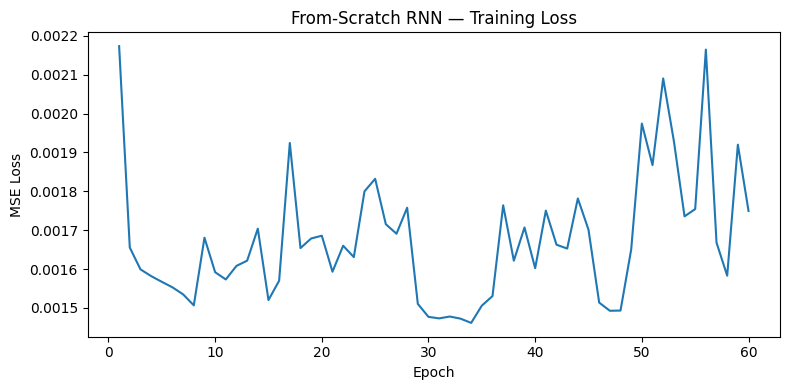

In [ ]:
# Prepare NumPy views (shape: (N, seq_len, 1))
Xtr_np = X_train.reshape(X_train.shape[0], X_train.shape[1], 1).astype(np.float32)
ytr_np = y_train.reshape(-1, 1).astype(np.float32)

Xte_np = X_test.reshape(X_test.shape[0], X_test.shape[1], 1).astype(np.float32)
yte_np = y_test.reshape(-1, 1).astype(np.float32)

rnn_np = RNNFromScratch(input_size=1, hidden_size=32, output_size=1, lr=5e-2, clip=5.0)

EPOCHS = 60
losses_np = []
for ep in range(EPOCHS):
    epoch_loss = 0.0
    for i in range(len(Xtr_np)):
        xseq = Xtr_np[i]                     # (seq_len, 1)
        ytrue = ytr_np[i]                    # (1,)
        y_hat, cache = rnn_np.forward(xseq)  # y_hat: (1,)
        loss = rnn_np.loss(y_hat, ytrue)
        rnn_np.backward(y_hat, ytrue, cache)
        rnn_np.step()
        epoch_loss += float(loss)
    epoch_loss /= len(Xtr_np)
    losses_np.append(epoch_loss)
    if (ep + 1) % 10 == 0:
        print(f"[Scratch] Epoch {ep+1}/{EPOCHS}  Loss: {epoch_loss:.6f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS+1), losses_np)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("From-Scratch RNN — Training Loss")
plt.tight_layout()
plt.show()

## Evaluate (From‑Scratch)

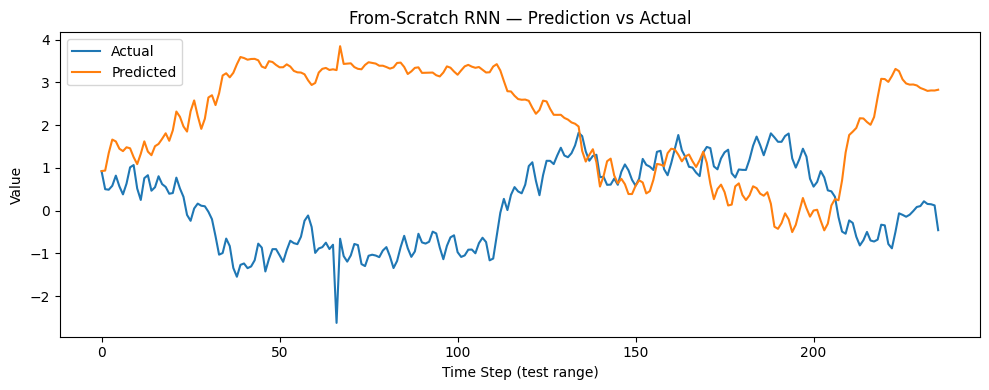

In [ ]:
# Predict test set
preds_np = []
for i in range(len(Xte_np)):
    xseq = Xte_np[i]
    y_hat, _ = rnn_np.forward(xseq)
    preds_np.append(float(y_hat.reshape(-1)[0]))

preds_np = np.array(preds_np)
# Inverse transform back to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
pred_inv_np = scaler.inverse_transform(preds_np.reshape(-1, 1)).ravel()

plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label="Actual")
plt.plot(pred_inv_np, label="Predicted")
plt.title("From-Scratch RNN — Prediction vs Actual")
plt.xlabel("Time Step (test range)")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# Part II — RNN with PyTorch

In [ ]:
class BasicRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)   # (batch, seq, hidden)
        out_last = out[:, -1, :]
        return self.fc(out_last)

model = BasicRNN(input_size=1, hidden_size=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

## Train (PyTorch)

[Torch] Epoch 10/100  Loss: 0.014244
[Torch] Epoch 20/100  Loss: 0.010276
[Torch] Epoch 30/100  Loss: 0.016238
[Torch] Epoch 40/100  Loss: 0.009020
[Torch] Epoch 50/100  Loss: 0.006149
[Torch] Epoch 60/100  Loss: 0.008310
[Torch] Epoch 70/100  Loss: 0.007227
[Torch] Epoch 80/100  Loss: 0.004515
[Torch] Epoch 90/100  Loss: 0.003193
[Torch] Epoch 100/100  Loss: 0.003114


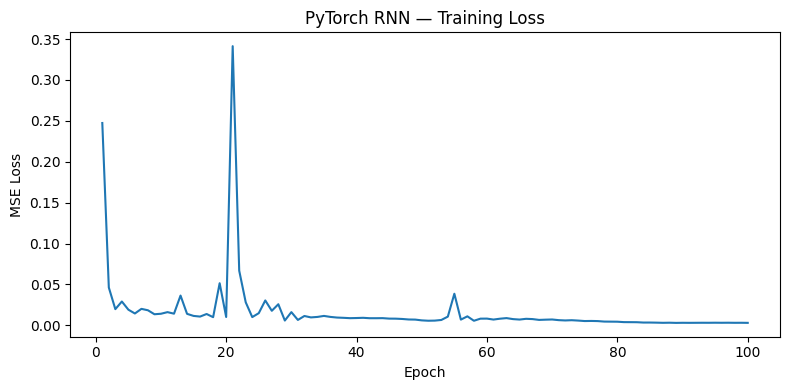

In [ ]:
EPOCHS_T = 100
losses_t = []

for ep in range(EPOCHS_T):
    model.train()
    optimizer.zero_grad()
    out = model(X_train_t).squeeze()
    loss = criterion(out, y_train_t)
    loss.backward()
    optimizer.step()

    losses_t.append(float(loss.item()))
    if (ep + 1) % 10 == 0:
        print(f"[Torch] Epoch {ep+1}/{EPOCHS_T}  Loss: {loss.item():.6f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS_T+1), losses_t)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("PyTorch RNN — Training Loss")
plt.tight_layout()
plt.show()

## Evaluate and Visualize (PyTorch)

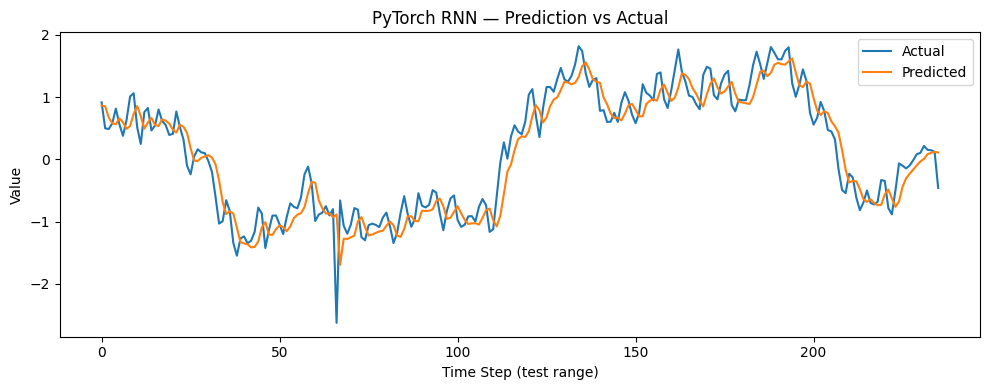

In [ ]:
model.eval()
with torch.no_grad():
    preds_t = model(X_test_t).squeeze().cpu().numpy()

y_test_inv_t = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
pred_inv_t = scaler.inverse_transform(preds_t.reshape(-1, 1)).ravel()

plt.figure(figsize=(10, 4))
plt.plot(y_test_inv_t, label="Actual")
plt.plot(pred_inv_t, label="Predicted")
plt.title("PyTorch RNN — Prediction vs Actual")
plt.xlabel("Time Step (test range)")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

----
# Homework
1. ต้องการคาดการณ์กราฟการลงทุนด้วยโมเดล RNN ของตัวเอง (ใช้ PyTorch) โดยกำหนดให้ ใส่รหัสนักศึกษา 4 ตัวสุดท้ายลงในจำนวนจุดของข้อมูล (n_points) ตัวอย่างเช่น
- 66010723 ดังนั้น n_points = 723
- หากรหัสนักศึกษ 4 ตัวท้ายอยู่ในช่วง 0001-0099 ให้ใช้เลขคณะ (01) ด้วย เช่น 66010002 --> n_points = 10002

ตัวอย่างกราฟการลงทุนอ้างอิงตามฟังก์ชั่นข้างใต้

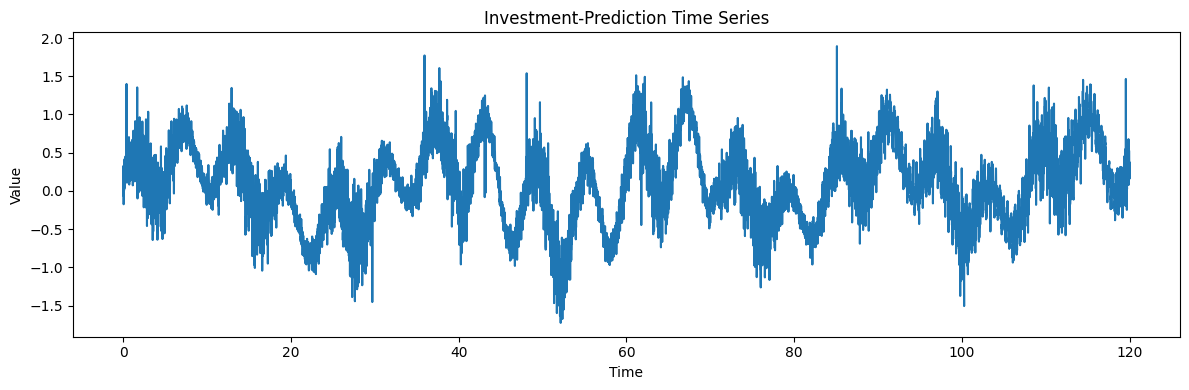

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# In case: the last four digit of student ID is 0002
def generate_complex_series(n_points=10002, t_end=120.0, seed=42):
    rng = np.random.default_rng(seed)
    t = np.linspace(0.0, t_end, n_points)

    # 1) Nonlinear trend
    trend = 0.02 * (t / t_end) + 0.15 * (t / t_end) ** 2

    # 2) Multi-seasonality
    slow = 0.001  * np.sin(2*np.pi * t / 18.0)
    med  = 0.001 * np.sin(2*np.pi * t / 3.5 + 0.6)
    fast = 0.001 * np.sin(2*np.pi * t / 0.7 + 1.3)

    # 3) Chirp (frequency increases)
    f0, k = 0.03, 0.015
    chirp = 0.45 * np.sin(2*np.pi * (f0*t + 0.5 * k * (t**2) / t_end))

    # 4) Regime shift + a new high-freq after t>90
    regime = np.ones_like(t)
    regime[(t >= 40) & (t <= 70)] = 1.7
    regime_component = regime * (0.4 * np.sin(2*np.pi * t / 6.0 + 0.3))
    post90 = np.where(t > 90, 0.2 * np.sin(2*np.pi * t / 0.45), 0.0)

    # 5) Heteroscedastic AR(1) noise
    sigma_t = 0.08 + 0.20 * (np.sin(2*np.pi * t / 12.0) + 1.0) / 2.0
    rho = 0.2
    eps = np.zeros_like(t)
    base_noise = rng.normal(0.0, 1.0, size=t.shape)
    for i in range(1, len(t)):
        eps[i] = rho * eps[i-1] + sigma_t[i] * base_noise[i]

    # 6) Spikes/outliers (~1%)
    y = (trend + slow + med + fast + chirp + regime_component + post90 + eps)
    n_spikes = int(0.001 * n_points)
    idx = rng.choice(n_points, size=n_spikes, replace=False)
    sign = rng.choice([-1.0, 1.0], size=n_spikes)
    y[idx] += sign * 2.5 * np.std(y)

    return t, y

# Generate + plot
t, y = generate_complex_series()
df = pd.DataFrame({"time": t, "value": y})

plt.figure(figsize=(12, 4))
plt.plot(df["time"], df["value"])
plt.title("Investment-Prediction Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


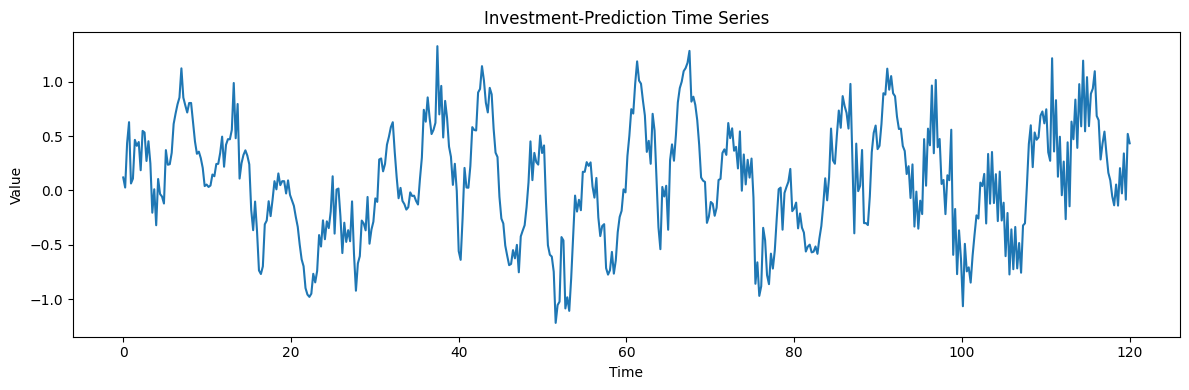

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# In case: the last four digit of student ID is 0520
def generate_complex_series(n_points=520, t_end=120.0, seed=42):
    rng = np.random.default_rng(seed)
    t = np.linspace(0.0, t_end, n_points)

    # 1) Nonlinear trend
    trend = 0.02 * (t / t_end) + 0.15 * (t / t_end) ** 2

    # 2) Multi-seasonality
    slow = 0.001  * np.sin(2*np.pi * t / 18.0)
    med  = 0.001 * np.sin(2*np.pi * t / 3.5 + 0.6)
    fast = 0.001 * np.sin(2*np.pi * t / 0.7 + 1.3)

    # 3) Chirp (frequency increases)
    f0, k = 0.03, 0.015
    chirp = 0.45 * np.sin(2*np.pi * (f0*t + 0.5 * k * (t**2) / t_end))

    # 4) Regime shift + a new high-freq after t>90
    regime = np.ones_like(t)
    regime[(t >= 40) & (t <= 70)] = 1.7
    regime_component = regime * (0.4 * np.sin(2*np.pi * t / 6.0 + 0.3))
    post90 = np.where(t > 90, 0.2 * np.sin(2*np.pi * t / 0.45), 0.0)

    # 5) Heteroscedastic AR(1) noise
    sigma_t = 0.08 + 0.20 * (np.sin(2*np.pi * t / 12.0) + 1.0) / 2.0
    rho = 0.2
    eps = np.zeros_like(t)
    base_noise = rng.normal(0.0, 1.0, size=t.shape)
    for i in range(1, len(t)):
        eps[i] = rho * eps[i-1] + sigma_t[i] * base_noise[i]

    # 6) Spikes/outliers (~1%)
    y = (trend + slow + med + fast + chirp + regime_component + post90 + eps)
    n_spikes = int(0.001 * n_points)
    idx = rng.choice(n_points, size=n_spikes, replace=False)
    sign = rng.choice([-1.0, 1.0], size=n_spikes)
    y[idx] += sign * 2.5 * np.std(y)

    return t, y

# Generate + plot
t, y = generate_complex_series()
df = pd.DataFrame({"time": t, "value": y})

plt.figure(figsize=(12, 4))
plt.plot(df["time"], df["value"])
plt.title("Investment-Prediction Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


Generating investment time series with n_points = 421 (Student ID: 65010421)


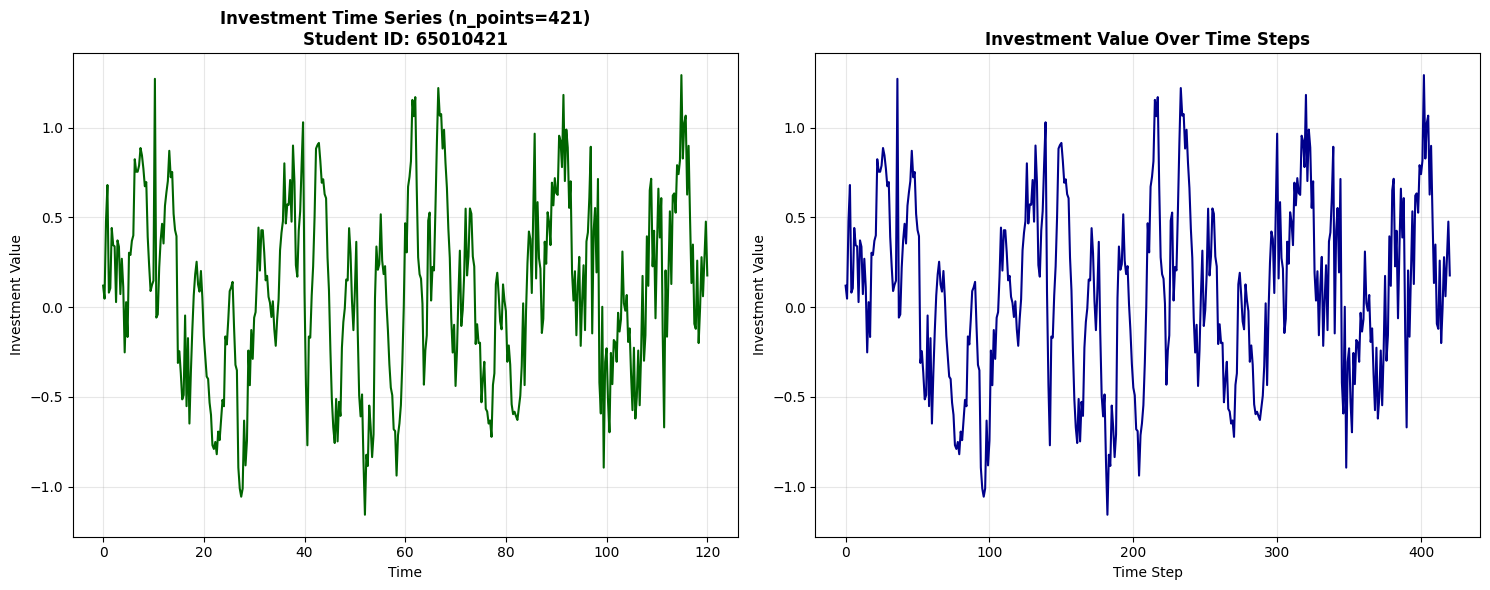

Data shape: (421, 2)
Time range: 0.00 to 120.00
Value range: -1.1557 to 1.2920
Data statistics:
count    421.000000
mean       0.094719
std        0.501636
min       -1.155665
25%       -0.242149
50%        0.109799
75%        0.464248
max        1.291974
Name: value, dtype: float64


In [1]:
# Student ID: 65010421
# Last 4 digits: 0421, so n_points = 421

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

def generate_investment_series(n_points=421, t_end=120.0, seed=42):
    """Generate investment time series with n_points = 421 (from student ID: 65010421)"""
    rng = np.random.default_rng(seed)
    t = np.linspace(0.0, t_end, n_points)

    # 1) Nonlinear upward trend (simulating long-term growth)
    trend = 0.02 * (t / t_end) + 0.15 * (t / t_end) ** 2

    # 2) Multi-seasonality (market cycles)
    slow = 0.001 * np.sin(2*np.pi * t / 18.0)  # Long-term cycle
    med  = 0.001 * np.sin(2*np.pi * t / 3.5 + 0.6)  # Medium-term cycle
    fast = 0.001 * np.sin(2*np.pi * t / 0.7 + 1.3)  # Short-term volatility

    # 3) Chirp (frequency increases over time - representing market acceleration)
    f0, k = 0.03, 0.015
    chirp = 0.45 * np.sin(2*np.pi * (f0*t + 0.5 * k * (t**2) / t_end))

    # 4) Regime shift (bull/bear markets)
    regime = np.ones_like(t)
    regime[(t >= 40) & (t <= 70)] = 1.7  # Bull market period
    regime_component = regime * (0.4 * np.sin(2*np.pi * t / 6.0 + 0.3))
    
    # Additional volatility in later periods
    post90 = np.where(t > 90, 0.2 * np.sin(2*np.pi * t / 0.45), 0.0)

    # 5) Heteroscedastic AR(1) noise (changing volatility)
    sigma_t = 0.08 + 0.20 * (np.sin(2*np.pi * t / 12.0) + 1.0) / 2.0
    rho = 0.2  # Lower autocorrelation for more randomness
    eps = np.zeros_like(t)
    base_noise = rng.normal(0.0, 1.0, size=t.shape)
    for i in range(1, len(t)):
        eps[i] = rho * eps[i-1] + sigma_t[i] * base_noise[i]

    # 6) Rare market shocks/outliers (~0.1%)
    y = (trend + slow + med + fast + chirp + regime_component + post90 + eps)
    n_spikes = max(1, int(0.001 * n_points))  # At least 1 spike
    idx = rng.choice(n_points, size=n_spikes, replace=False)
    sign = rng.choice([-1.0, 1.0], size=n_spikes)
    y[idx] += sign * 2.5 * np.std(y)

    return t, y

# Generate investment time series
print(f"Generating investment time series with n_points = 421 (Student ID: 65010421)")
t_invest, y_invest = generate_investment_series(n_points=421)
df_invest = pd.DataFrame({"time": t_invest, "value": y_invest})

# Plot the generated investment series
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(df_invest["time"], df_invest["value"], linewidth=1.5, color='darkgreen')
plt.title("Investment Time Series (n_points=421)\nStudent ID: 65010421", fontsize=12, fontweight='bold')
plt.xlabel("Time")
plt.ylabel("Investment Value")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(df_invest["value"], linewidth=1.5, color='darkblue')
plt.title("Investment Value Over Time Steps", fontsize=12, fontweight='bold')
plt.xlabel("Time Step")
plt.ylabel("Investment Value")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Data shape: {df_invest.shape}")
print(f"Time range: {df_invest['time'].min():.2f} to {df_invest['time'].max():.2f}")
print(f"Value range: {df_invest['value'].min():.4f} to {df_invest['value'].max():.4f}")
print(f"Data statistics:")
print(df_invest['value'].describe())

Original series length: 421
Number of sequences created: 406
Sequence shape: (406, 15)
Target shape: (406,)

Train set: 324 sequences
Test set: 82 sequences
PyTorch tensor shapes:
X_train: torch.Size([324, 15, 1])
y_train: torch.Size([324])
X_test: torch.Size([82, 15, 1])
y_test: torch.Size([82])


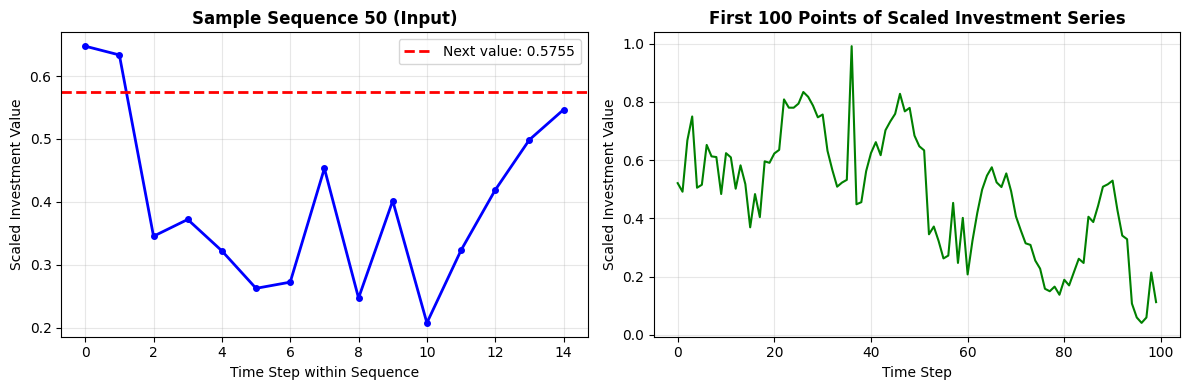

In [2]:
# Data Preprocessing and Sequence Creation for Investment Prediction

# Scale the investment data
scaler_invest = MinMaxScaler()
df_invest['value_scaled'] = scaler_invest.fit_transform(df_invest[['value']])
series_invest = df_invest['value_scaled'].values

def create_investment_sequences(arr, seq_len: int):
    """Create sequences for time series prediction"""
    xs, ys = [], []
    for i in range(len(arr) - seq_len):
        x = arr[i:i+seq_len]
        y = arr[i+seq_len]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences with different sequence lengths to test
SEQ_LEN_INVEST = 15  # Use 15 time steps to predict the next value
X_invest, y_invest = create_investment_sequences(series_invest, SEQ_LEN_INVEST)

print(f"Original series length: {len(series_invest)}")
print(f"Number of sequences created: {len(X_invest)}")
print(f"Sequence shape: {X_invest.shape}")
print(f"Target shape: {y_invest.shape}")

# Split data (80% train, 20% test) - maintaining temporal order
split_idx = int(0.8 * len(X_invest))
X_train_invest = X_invest[:split_idx]
X_test_invest = X_invest[split_idx:]
y_train_invest = y_invest[:split_idx]
y_test_invest = y_invest[split_idx:]

print(f"\nTrain set: {X_train_invest.shape[0]} sequences")
print(f"Test set: {X_test_invest.shape[0]} sequences")

# Convert to PyTorch tensors
X_train_invest_t = torch.tensor(X_train_invest, dtype=torch.float32).unsqueeze(-1)
y_train_invest_t = torch.tensor(y_train_invest, dtype=torch.float32)
X_test_invest_t = torch.tensor(X_test_invest, dtype=torch.float32).unsqueeze(-1)
y_test_invest_t = torch.tensor(y_test_invest, dtype=torch.float32)

print(f"PyTorch tensor shapes:")
print(f"X_train: {X_train_invest_t.shape}")
print(f"y_train: {y_train_invest_t.shape}")
print(f"X_test: {X_test_invest_t.shape}")
print(f"y_test: {y_test_invest_t.shape}")

# Visualize a sample sequence
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sample_idx = 50
plt.plot(X_train_invest[sample_idx], 'b-o', linewidth=2, markersize=4)
plt.axhline(y=y_train_invest[sample_idx], color='red', linestyle='--', linewidth=2, 
           label=f'Next value: {y_train_invest[sample_idx]:.4f}')
plt.title(f'Sample Sequence {sample_idx} (Input)', fontweight='bold')
plt.xlabel('Time Step within Sequence')
plt.ylabel('Scaled Investment Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(series_invest[:100], linewidth=1.5, color='green')
plt.title('First 100 Points of Scaled Investment Series', fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Scaled Investment Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# Investment Prediction RNN Model (PyTorch Implementation)

class InvestmentRNN(nn.Module):
    """
    RNN model specifically designed for investment time series prediction
    """
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layers with dropout for regularization
        self.rnn = nn.RNN(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        batch_size = x.size(0)
        
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward pass through RNN
        out, _ = self.rnn(x, h0)  # out shape: (batch_size, seq_len, hidden_size)
        
        # Take the output from the last time step
        out_last = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        
        # Apply dropout
        out_last = self.dropout(out_last)
        
        # Final prediction
        prediction = self.fc(out_last)  # Shape: (batch_size, 1)
        
        return prediction.squeeze()  # Shape: (batch_size,)

# Create the investment prediction model
print("Creating Investment Prediction RNN Model...")
investment_model = InvestmentRNN(
    input_size=1, 
    hidden_size=128,  # Larger hidden size for more capacity
    num_layers=3,     # Deeper network for complex patterns
    dropout=0.3       # Higher dropout for regularization
)

# Loss function and optimizer
criterion_invest = nn.MSELoss()
optimizer_invest = optim.Adam(investment_model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler_invest = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_invest, mode='min', factor=0.5, patience=10
)

print(f"Model architecture:")
print(investment_model)
print(f"\nTotal parameters: {sum(p.numel() for p in investment_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in investment_model.parameters() if p.requires_grad):,}")

Creating Investment Prediction RNN Model...
Model architecture:
InvestmentRNN(
  (rnn): RNN(1, 128, num_layers=3, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Total parameters: 82,945
Trainable parameters: 82,945


Starting training...
Epoch [ 10/150] | Train Loss: 0.042837 | Val Loss: 0.026102 | LR: 1.00e-03
Epoch [ 20/150] | Train Loss: 0.022834 | Val Loss: 0.019126 | LR: 1.00e-03
Epoch [ 30/150] | Train Loss: 0.016956 | Val Loss: 0.018260 | LR: 1.00e-03
Epoch [ 40/150] | Train Loss: 0.017815 | Val Loss: 0.017766 | LR: 1.00e-03
Epoch [ 50/150] | Train Loss: 0.015027 | Val Loss: 0.016900 | LR: 1.00e-03
Epoch [ 60/150] | Train Loss: 0.015266 | Val Loss: 0.017143 | LR: 5.00e-04

Early stopping at epoch 62
Best validation loss: 0.016805
Training completed!
Final train loss: 0.014398
Final validation loss: 0.017354
Best validation loss: 0.016805


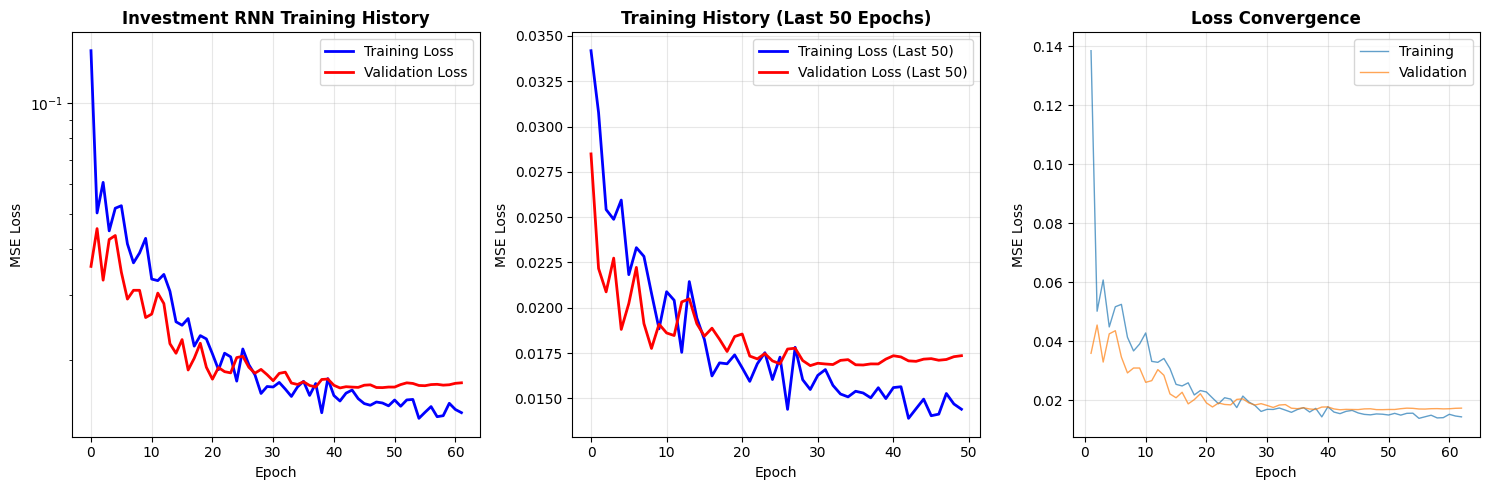

In [5]:
# Training the Investment Prediction RNN

def train_investment_model(model, X_train, y_train, X_test, y_test, 
                          criterion, optimizer, scheduler, epochs=150):
    """
    Train the investment RNN model with validation
    """
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 20
    
    print("Starting training...")
    print("=" * 60)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        train_pred = model(X_train)
        train_loss = criterion(train_pred, y_train)
        
        # Backward pass
        train_loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_pred = model(X_test)
            val_loss = criterion(val_pred, y_test)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1:3d}/{epochs}] | "
                  f"Train Loss: {train_loss.item():.6f} | "
                  f"Val Loss: {val_loss.item():.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= early_stop_patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.6f}")
            # Load best model
            model.load_state_dict(best_model_state)
            break
    
    print("=" * 60)
    print("Training completed!")
    print(f"Final train loss: {train_losses[-1]:.6f}")
    print(f"Final validation loss: {val_losses[-1]:.6f}")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    return train_losses, val_losses

# Train the model
train_losses_invest, val_losses_invest = train_investment_model(
    investment_model, 
    X_train_invest_t, y_train_invest_t,
    X_test_invest_t, y_test_invest_t,
    criterion_invest, optimizer_invest, scheduler_invest,
    epochs=150
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses_invest, label='Training Loss', linewidth=2, color='blue')
plt.plot(val_losses_invest, label='Validation Loss', linewidth=2, color='red')
plt.title('Investment RNN Training History', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(1, 3, 2)
plt.plot(train_losses_invest[-50:], label='Training Loss (Last 50)', linewidth=2, color='blue')
plt.plot(val_losses_invest[-50:], label='Validation Loss (Last 50)', linewidth=2, color='red')
plt.title('Training History (Last 50 Epochs)', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
epoch_range = range(1, len(train_losses_invest) + 1)
plt.plot(epoch_range, train_losses_invest, label='Training', alpha=0.7, linewidth=1)
plt.plot(epoch_range, val_losses_invest, label='Validation', alpha=0.7, linewidth=1)
plt.title('Loss Convergence', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

INVESTMENT PREDICTION RESULTS
Student ID: 65010421 | Data points: 421 | Sequence length: 15
----------------------------------------------------------------------
TRAINING SET METRICS:
  MSE:  0.065671
  MAE:  0.197369
  R²:   0.754524
----------------------------------------------------------------------
TEST SET METRICS:
  MSE:  0.103964
  MAE:  0.262465
  R²:   0.525009


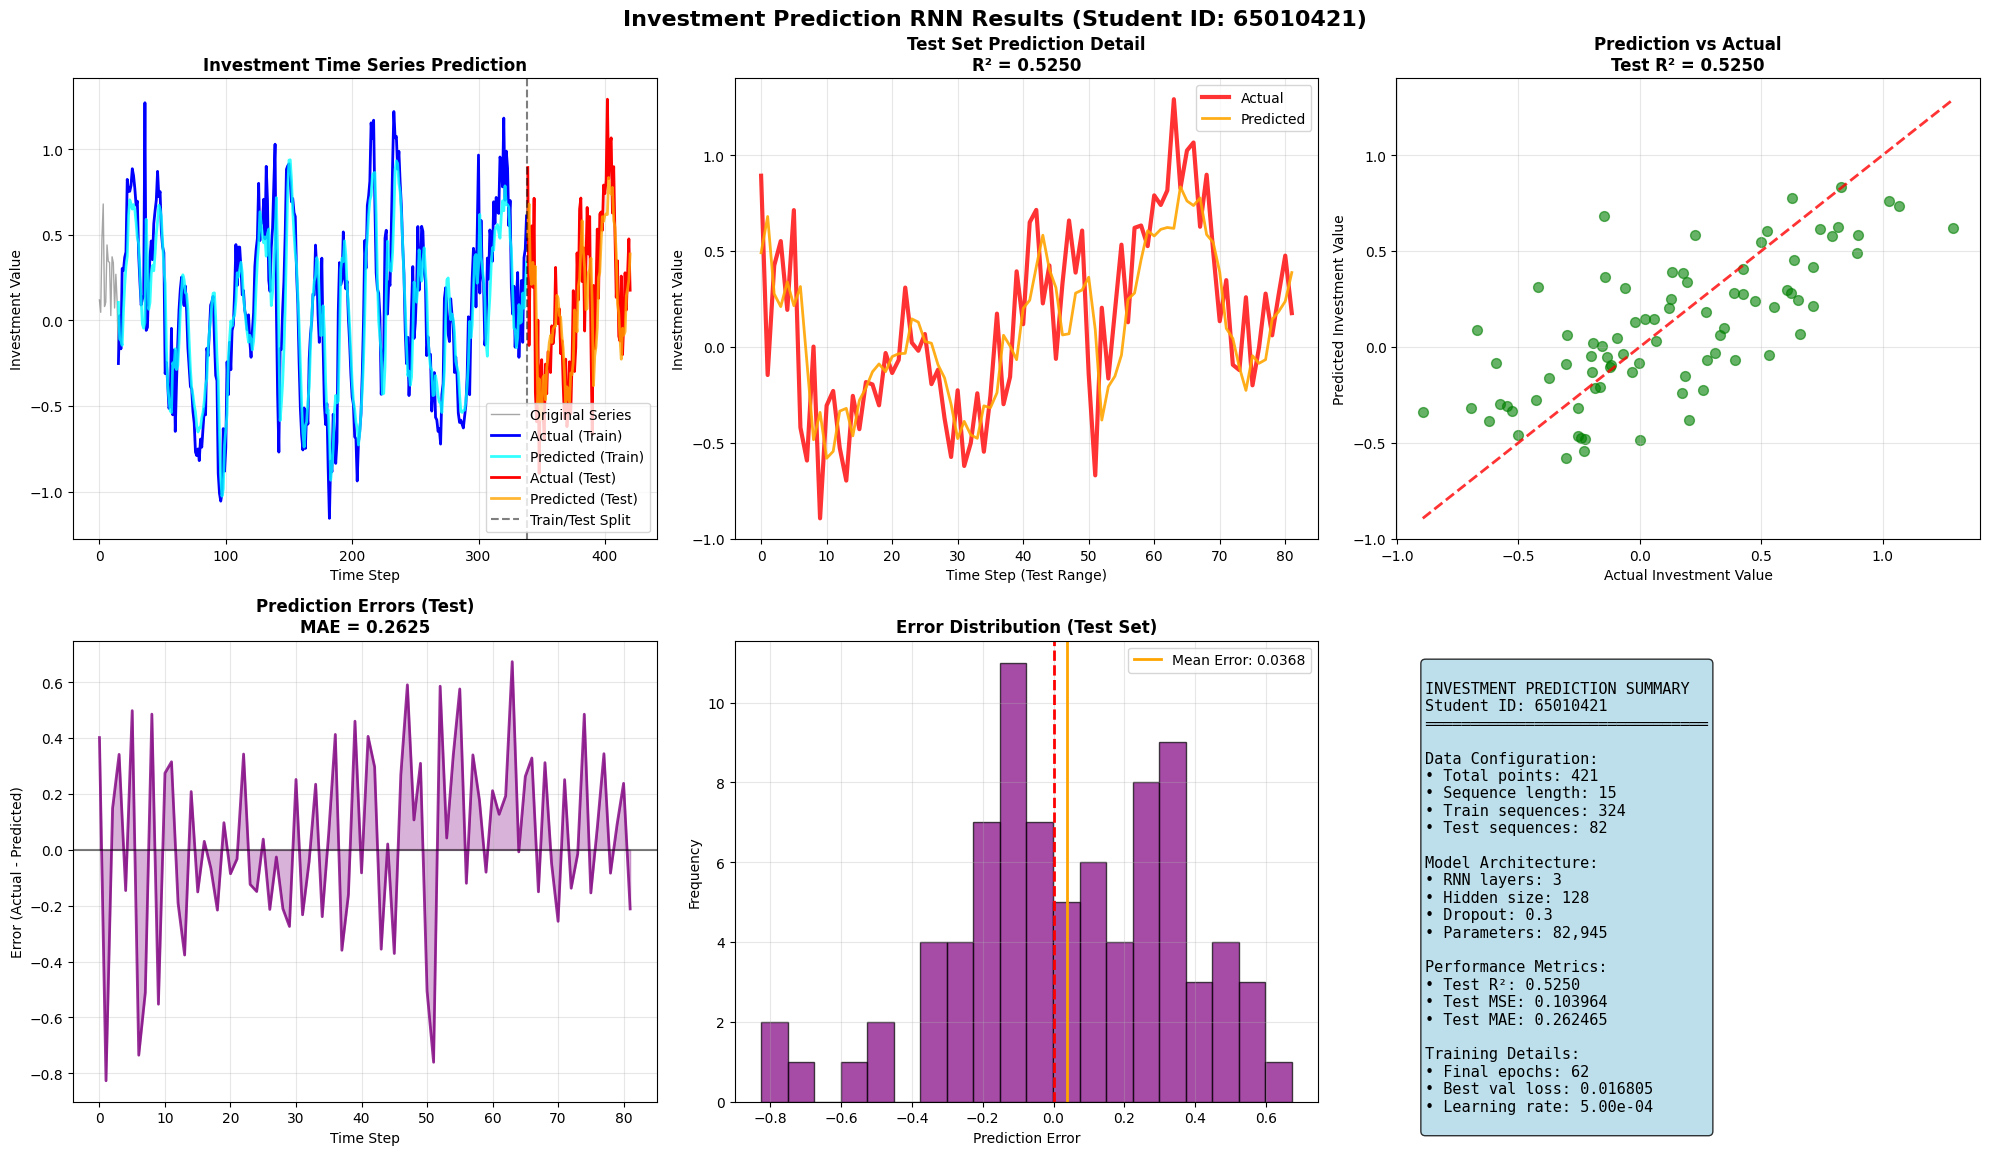


FUTURE INVESTMENT PREDICTION ANALYSIS
Last actual value: 0.1766
Last predicted value: 0.3881
Error: 0.2115

Next 10 predicted investment values:
  t+1: 0.3881
  t+2: 0.4205
  t+3: 0.3918
  t+4: 0.3540
  t+5: 0.3023
  t+6: 0.2285
  t+7: 0.1473
  t+8: 0.0659
  t+9: -0.0090
  t+10: -0.0718

Predicted trend: Downward
Prediction range: -0.0718 to 0.4205


In [6]:
# Model Evaluation and Investment Prediction Visualization

# Make predictions on both training and test sets
investment_model.eval()
with torch.no_grad():
    # Training predictions
    train_pred_invest = investment_model(X_train_invest_t).cpu().numpy()
    # Test predictions
    test_pred_invest = investment_model(X_test_invest_t).cpu().numpy()

# Convert back to original scale
y_train_original = scaler_invest.inverse_transform(y_train_invest.reshape(-1, 1)).ravel()
train_pred_original = scaler_invest.inverse_transform(train_pred_invest.reshape(-1, 1)).ravel()

y_test_original = scaler_invest.inverse_transform(y_test_invest.reshape(-1, 1)).ravel()
test_pred_original = scaler_invest.inverse_transform(test_pred_invest.reshape(-1, 1)).ravel()

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Training metrics
train_mse = mean_squared_error(y_train_original, train_pred_original)
train_mae = mean_absolute_error(y_train_original, train_pred_original)
train_r2 = r2_score(y_train_original, train_pred_original)

# Test metrics
test_mse = mean_squared_error(y_test_original, test_pred_original)
test_mae = mean_absolute_error(y_test_original, test_pred_original)
test_r2 = r2_score(y_test_original, test_pred_original)

print("=" * 70)
print("INVESTMENT PREDICTION RESULTS")
print("=" * 70)
print(f"Student ID: 65010421 | Data points: {len(df_invest)} | Sequence length: {SEQ_LEN_INVEST}")
print("-" * 70)
print("TRAINING SET METRICS:")
print(f"  MSE:  {train_mse:.6f}")
print(f"  MAE:  {train_mae:.6f}")
print(f"  R²:   {train_r2:.6f}")
print("-" * 70)
print("TEST SET METRICS:")
print(f"  MSE:  {test_mse:.6f}")
print(f"  MAE:  {test_mae:.6f}")
print(f"  R²:   {test_r2:.6f}")
print("=" * 70)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Investment Prediction RNN Results (Student ID: 65010421)', fontsize=16, fontweight='bold')

# 1. Full time series with predictions
ax1 = axes[0, 0]
full_time = np.arange(len(df_invest))
train_time = full_time[SEQ_LEN_INVEST:SEQ_LEN_INVEST+len(y_train_original)]
test_time = full_time[SEQ_LEN_INVEST+len(y_train_original):SEQ_LEN_INVEST+len(y_train_original)+len(y_test_original)]

ax1.plot(full_time, df_invest['value'], label='Original Series', alpha=0.7, linewidth=1, color='gray')
ax1.plot(train_time, y_train_original, label='Actual (Train)', linewidth=2, color='blue')
ax1.plot(train_time, train_pred_original, label='Predicted (Train)', linewidth=2, color='cyan', alpha=0.8)
ax1.plot(test_time, y_test_original, label='Actual (Test)', linewidth=2, color='red')
ax1.plot(test_time, test_pred_original, label='Predicted (Test)', linewidth=2, color='orange', alpha=0.8)
ax1.axvline(x=train_time[-1], color='black', linestyle='--', alpha=0.5, label='Train/Test Split')
ax1.set_title('Investment Time Series Prediction', fontweight='bold')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Investment Value')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Test set prediction detail
ax2 = axes[0, 1]
ax2.plot(y_test_original, label='Actual', linewidth=3, color='red', alpha=0.8)
ax2.plot(test_pred_original, label='Predicted', linewidth=2, color='orange', alpha=0.9)
ax2.set_title(f'Test Set Prediction Detail\nR² = {test_r2:.4f}', fontweight='bold')
ax2.set_xlabel('Time Step (Test Range)')
ax2.set_ylabel('Investment Value')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Prediction vs Actual scatter plot
ax3 = axes[0, 2]
ax3.scatter(y_test_original, test_pred_original, alpha=0.6, color='green', s=50)
min_val = min(y_test_original.min(), test_pred_original.min())
max_val = max(y_test_original.max(), test_pred_original.max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)
ax3.set_title(f'Prediction vs Actual\nTest R² = {test_r2:.4f}', fontweight='bold')
ax3.set_xlabel('Actual Investment Value')
ax3.set_ylabel('Predicted Investment Value')
ax3.grid(True, alpha=0.3)

# 4. Prediction errors
ax4 = axes[1, 0]
test_errors = y_test_original - test_pred_original
ax4.plot(test_errors, linewidth=2, color='purple', alpha=0.8)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.fill_between(range(len(test_errors)), test_errors, alpha=0.3, color='purple')
ax4.set_title(f'Prediction Errors (Test)\nMAE = {test_mae:.4f}', fontweight='bold')
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Error (Actual - Predicted)')
ax4.grid(True, alpha=0.3)

# 5. Error distribution
ax5 = axes[1, 1]
ax5.hist(test_errors, bins=20, alpha=0.7, color='purple', edgecolor='black')
ax5.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax5.axvline(x=test_errors.mean(), color='orange', linestyle='-', linewidth=2, 
           label=f'Mean Error: {test_errors.mean():.4f}')
ax5.set_title('Error Distribution (Test Set)', fontweight='bold')
ax5.set_xlabel('Prediction Error')
ax5.set_ylabel('Frequency')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Model performance summary
ax6 = axes[1, 2]
ax6.axis('off')
performance_text = f"""
INVESTMENT PREDICTION SUMMARY
Student ID: 65010421
═══════════════════════════════

Data Configuration:
• Total points: {len(df_invest)}
• Sequence length: {SEQ_LEN_INVEST}
• Train sequences: {len(X_train_invest)}
• Test sequences: {len(X_test_invest)}

Model Architecture:
• RNN layers: 3
• Hidden size: 128
• Dropout: 0.3
• Parameters: {sum(p.numel() for p in investment_model.parameters()):,}

Performance Metrics:
• Test R²: {test_r2:.4f}
• Test MSE: {test_mse:.6f}
• Test MAE: {test_mae:.6f}

Training Details:
• Final epochs: {len(train_losses_invest)}
• Best val loss: {min(val_losses_invest):.6f}
• Learning rate: {optimizer_invest.param_groups[0]['lr']:.2e}
"""
ax6.text(0.05, 0.95, performance_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Additional analysis: Future prediction
print("\n" + "="*50)
print("FUTURE INVESTMENT PREDICTION ANALYSIS")
print("="*50)

# Predict next 10 time steps
def predict_future(model, last_sequence, scaler, n_future=10):
    """Predict future values using the trained model"""
    model.eval()
    future_predictions = []
    current_seq = last_sequence.copy()
    
    with torch.no_grad():
        for _ in range(n_future):
            # Prepare input tensor
            input_tensor = torch.tensor(current_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
            
            # Make prediction
            pred = model(input_tensor).item()
            future_predictions.append(pred)
            
            # Update sequence for next prediction
            current_seq = np.append(current_seq[1:], pred)
    
    # Convert back to original scale
    future_original = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).ravel()
    return future_original

# Get the last sequence from test data
last_sequence = X_test_invest[-1]
future_pred = predict_future(investment_model, last_sequence, scaler_invest, n_future=10)

print(f"Last actual value: {y_test_original[-1]:.4f}")
print(f"Last predicted value: {test_pred_original[-1]:.4f}")
print(f"Error: {abs(y_test_original[-1] - test_pred_original[-1]):.4f}")
print("\nNext 10 predicted investment values:")
for i, pred in enumerate(future_pred, 1):
    print(f"  t+{i}: {pred:.4f}")

print(f"\nPredicted trend: {'Upward' if future_pred[-1] > future_pred[0] else 'Downward'}")
print(f"Prediction range: {future_pred.min():.4f} to {future_pred.max():.4f}")
print("="*50)